# Accessing Data paper code

This code was used in my MSc to produce a paper about OSM. It then formed the basis for a more complete approach using only HTML web scraping (no RSS feed) and a different approach to storing data, as part of my MSc thesis - addressing many of the issues with this approach which are discussed in the paper. 

For more information see the [paper](https://docs.google.com/document/d/1ZZvyY366r5glFlgblz3Sf2mJO8DrmmfNOvVCcaETHnQ/edit?usp=sharing) and the [short write up](https://www.jamiefawcett.org.uk/project/masters-accessing-data).

In [1]:
import requests
from bs4 import BeautifulSoup as bs
import feedparser as fp
import pandas as pd
import re 
import datetime
import numpy as np
# import pprint as pp

## Data collection

In [4]:
#A way to extract relevant data from a single topic's RSS feed from URL

#get the rss feed from a url
def getrss(url):
    feed = fp.parse(url)
    entries = feed['entries']
    return entries

#gets all the feeds from topic url
def getPosts(topic_url):
    topic_id = topic_url.split("?")[1]
    topic_rss = "https://forum.openstreetmap.org/extern.php?action=feed&t%s&type=atom"%topic_id
    feed = fp.parse(topic_rss)
    topic_feed = feed['entries']
    
    if len(topic_feed) == 0:
        error = "ERROR: Couldn't find anything for %s" %topic_id
        print(error)
        with open("error_log{}.txt".format(datetime.datetime.now().date()),"a") as errorfile:
            errorfile.write("Topic Empty Error: " + topic_id + "-" + str(datetime.datetime.now().time()) + "\n")
        return None
        
    else:
        try:
            posts = []
            for c,entry in enumerate(topic_feed):
                post = {}
                post["author"] = entry['author']
                post["time"] = entry['updated_parsed']                
                post_df = pd.DataFrame([post.values()],index=["{}.{}".format(topic_id,c)], columns=post.keys()) #
                posts.append(post_df)

        except KeyError:
            print("ERROR: Something went wrong with ID")
            with open("error_log{}.txt".format(datetime.datetime.now().date()),"a") as errorfile:
                errorfile.write("ID Error: " + topic_url + "-" +  str(datetime.datetime.now().time()) + "\n")
            
    if len(posts) == 0:
        return None
    else:
        topic_df = pd.concat(posts,axis=0)
        
    return topic_df


In [ ]:
# A way to get all RSS feeds from any sub-forum page 

#A function to extract topic titles and links from sub-forums
def getTopics(forum_page):
    soup = bs(forum_page)
    topics_stuff = []
    try:
        for row in soup.findAll('tr',{"class": ["roweven","rowodd"]}):
            topic_link = row.find("div",{"class":"tclcon"}).a.get("href")
            posts = getPosts(topic_link)
            try:
                posts["topic_link"] = topic_link
                posts["topic_title"] = row.find("div",{"class":"tclcon"}).a.text
                posts["topic_reply_count"] = row.find('td',{"class": "tc2"}).text.strip()
                posts["topic_view_count"] = row.find('td',{"class": "tc3"}).text.strip()

            except TypeError: #to catch where no posts in topic
                print("Error, no posts in topic, skipping {}".format(topic_link))
                with open("error_log{}.txt".format(datetime.datetime.now().date()),"a") as errorfile:
                    errorfile.write("Post Error: " + topic_link + "-" + str(datetime.datetime.now().time()) + "\n")
                    
            topics_stuff.append(posts)
            
    except: #to catch where forum page has no topics
        print("ERROR: forum has no topics")
        with open("error_log{}.txt".format(datetime.datetime.now().date()),"w") as errorfile:
            errorfile.write("Forum Error: " + str(datetime.datetime.now().time()) + "\n")
        continue

    return topics_stuff

In [ ]:
#A function that gets the number of pages and then gets forum pages for each page
def getAllPages(sub_forum_id):
    first_page = requests.get('https://forum.openstreetmap.org/%s'%(sub_forum_id)).text
    soup = bs(first_page)
    page_nums = soup.find('p',{"class":"pagelink conl"})
    if len(page_nums.findAll("a")) == 0:
        max_page = 1
    else:
        numbers = [int(item.text) for item in page_nums.find_all("a") if item.text.isdigit()]
        max_page = max(numbers)
#     print("Getting %s pages" % (max_page))
    forum_topics =[]
    for page in range(0,max_page):
        page_num = page+1
        if page_num % 5 == 0:
            print('Processing %s pages...and counting'%(page_num)) 
        full_page = requests.get('https://forum.openstreetmap.org/%s&p=%s'%(sub_forum_id,page_num)).text
        topic_entries = getTopics(full_page)
        forum_topics.extend(topic_entries)
#     print("Processed all pages")
    forum_df = pd.concat(forum_topics,axis=0)
    return forum_df

In [ ]:
# This function wraps up all the previous functions
# starting from the index page and moving through each of the sub-forums

def getForums(index_url,filename): #include filename to write to
    index = requests.get(index_url).text
    soup = bs(index)
    
    #Catching file overwrite issues
    try:
        with open(filename,"rb") as filein:
            print("Something in this writing file already")
            filename = "{}_new.{}".format(filename.split(".")[0],filename.split(".")[1])
            print("Changed filename to {}".format(filename))

    except FileNotFoundError:
        print("Good to go, writing to {}".format(filename))

    try:
         with open("error_log{}.txt".format(datetime.datetime.now().date()),"rb") as errorfile:
            print("Something in this error file already")
            filename = "{}_new.{}".format(filename.split(".")[0],filename.split(".")[1])
            print("Changed filename to {}".format(filename))
    except FileNotFoundError:
        print("Good to go, writing errors")
            
    for c,row in enumerate(soup.findAll('tr',{"class": ["roweven","rowodd"]})):            
        title = row.find('h3').text.strip()
#         print("Getting pages for %s" % (title))

        link = row.find('h3').a.get("href").strip()
        forum_topics = getAllPages(link)
        forum_topics["forum_topic_count"] = row.find('td',{"class": "tc2"}).text.strip()
        forum_topics["Forum_post_count"] = row.find('td',{"class": "tc3"}).text.strip()
        forum_topics["forum_link"] = link
        forum_topics["forum_title"] = title

        forum_topics.to_csv(filename, mode ='a')
        completion = (c / len(soup.findAll('tr',{"class": ["roweven","rowodd"]})))*100
        print("Completed {0:.0f}% of forums".format(completion))

In [ ]:
#Running
getForums("https://forum.openstreetmap.org/index.php","real_{}.csv".format(datetime.datetime.now().date()))

### additional HTML scraping

In [ ]:
all_data = pd.read_csv('full_data_2019-02-12.csv',index_col=0)
all_data = all_data[all_data["topic_link"]!="topic_link"]

In [ ]:
topic_items = ["topic_link","topic_title","topic_reply_count","forum_title","forum_link"]
topic_df = all_data[topic_items].drop_duplicates().reset_index()
del topic_df['index']

In [ ]:
def removeDash(x):
    if x == '-':
        x = np.nan
    else:
        x = x.replace(",","")
    return float(x)

topic_df["topic_reply_count"] = topic_df["topic_reply_count"].map(lambda x: removeDash(x))

#create a df of all topics
missing_num = len(topic_df[topic_df["topic_reply_count"]>15])
# display(missing_num)
missing_topics = topic_df[topic_df["topic_reply_count"]>15]

In [ ]:
#gets all the HTML pages from topic url
def getaPosts(topic_url,page_num):
    topic_page = requests.get('https://forum.openstreetmap.org/%s&p=%s'%(topic_url,page_num)).text
    topic_id = topic_url.split("?")[1]
    soup = bs(topic_page)
    page_posts = []  
    for c,post in enumerate(soup.findAll("div",{"class":re.compile("(blockpost(?:.*))")})):

        if page_num == 1: #for first page, skip first 15 entries
            if c < 15:
                continue
                
        post_details = {}
        post_details["author"] = post.find("div",{"class":"postleft"}).find("dt").find("strong").text
        post_details["time"] = post.find("h2").span.a.text
        post_df = pd.DataFrame([post_details.values()],index=["{}.{}.{}".format(topic_id,page_num,c)], columns=post_details.keys()) #
        page_posts.append(post_df)
    topic_df = pd.concat(page_posts,axis=0)
    return topic_df

#A function that gets RSS feeds for the entire forum
def getMissingPosts(topic_url):
    first_page = requests.get('https://forum.openstreetmap.org/%s'%(topic_url)).text
    soup = bs(first_page)
    page_nums = soup.find('p',{"class":"pagelink conl"})
    if len(page_nums.findAll("a")) == 0:
        max_page = 1
    else:
        numbers = [int(item.text) for item in page_nums.find_all("a") if item.text.isdigit()]
        max_page = max(numbers)
    
    topics_feeds = []
    for page in range(0,max_page):
        page_num = page+1
        post_entries = getaPosts(topic_url,page_num)
        topics_feeds.append(post_entries)
    post_df = pd.concat(topics_feeds,axis=0)
    post_df["topic_link"] = topic_url
#     post_df.to_csv("missing_posts{}.csv".format(datetime.datetime.now().date()), mode ='a')
    return post_df
    

In [ ]:
missing_post_list = []
for c, topic_link in enumerate(missing_topics["topic_link"]):
    try:
        missing_post_list.append(getMissingPosts(topic_link))
    except ValueError:
        print("Error: no missing posts in {}".format(topic_link))
    if c%100 == 0:
        how = (c+1) / missing_num
        print("{}%".format(how*100))

missing_df = pd.concat(missing_post_list,axis=0)

combined_df = missing_df.merge(topic_df, on = "topic_link")
display(len(combined_df))

combined_df.to_csv("missing_posts.csv")

# Analysis

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

UsageError: Line magic function `%` not found.


## Checking and cleaning

In [ ]:
#append only -- means it all goes in -- drop title rows
all_data = all_data[all_data["topic_link"]!="topic_link"]

#merge in missing data
all_data = pd.read_csv('full_data_2019-02-12.csv',index_col=0)
# print(len(all_data))
missing_data = pd.read_csv('missing_posts.csv',index_col=0)
# print(len(missing_data))

# print(len(missing_data)+len(all_data))

combined_df = pd.concat([all_data,missing_data])
# print(len(combined_df))

In [ ]:
combined_df.to_csv("all_data_inc_missing2019-02-13.csv")

In [ ]:
#Check number of topics identified
print(len(combined_df["topic_title"].unique()))

## Contributor analysis

In [8]:
#getting number of contributions
all_contributors = combined_df["author"].value_counts()
print(len(all_contributors))

#Get stats on contributors
contrib_stats = pd.DataFrame(all_contributors.describe())
display(contrib_stats)
# contrib_stats.to_csv("contributor_stats.csv")

15138


,author
count,15138.000000
mean,19.684106
std,130.411214
min,1.000000
25%,1.000000
50%,2.000000
75%,6.000000
max,7222.000000


In [9]:
#Get the data required for plots and stats
contrib_count = pd.DataFrame(all_contributors.value_counts())

contrib_count.columns = ["num_contributors"]
contrib_count["num_contributions"] = contrib_count.index

contrib_count["contributions_by_group"] = contrib_count.apply(lambda x: x.loc["num_contributors"] * x.loc["num_contributions"],axis=1)

contrib_count["log_contributions"] = np.log(contrib_count["num_contributions"])
contrib_count["log_contributors"] = np.log(contrib_count["num_contributors"])

# contrib_count.to_csv("contribution_counts.csv")

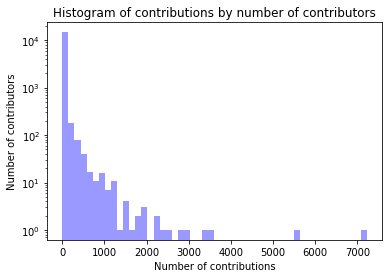

In [10]:
##Contrib plot
contrib_plot = sns.distplot(all_contributors,color="blue",kde=False)
plt.yscale('log')
contrib_plot.set_title("Histogram of contributions by number of contributors") #(log) 
contrib_plot.set(xlabel="Number of contributions",ylabel="Number of contributors")
fig = contrib_plot.get_figure()
fig.savefig("contributor_hist.png")
plt.show()

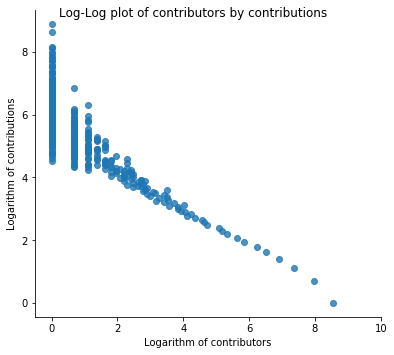

In [11]:
##Log-log plot
log_plot = sns.lmplot(x="log_contributors",y="log_contributions", data=contrib_count,aspect=1.1, fit_reg=False) #,color="blue"
log_plot.fig.suptitle("Log-Log plot of contributors by contributions")
plt.xlabel("Logarithm of contributors")
plt.ylabel("Logarithm of contributions")
plt.xlim(None, 10)
log_plot.savefig(fname ="contributor_scatter.png",dpi =500)
plt.show()

In [ ]:
## contributor split -- what % of users account for what % of contributions
total_contributions = contrib_count["contributions_by_group"].sum()
total_contributors = contrib_count["num_contributors"].sum()
# print(total_contributions)
# print(total_contributors)

percents = [90,95,99]

contrib_percents = []
for percent in percents:
    newdic = {}
    #take all that value or less and sum contributions / total contributions = gives tail
    percentile = np.percentile(all_contributors, percent)
    newdic["percentile"] = percentile
    newdic["tail"] = (contrib_count["contributions_by_group"][contrib_count["num_contributions"]<=percentile].sum()/total_contributions)*100
    # take all that value or more and sum contributions / total contributions = gives head
    newdic["head"] = (contrib_count["contributions_by_group"][contrib_count["num_contributions"]>=percentile].sum()/total_contributions)*100
    temp_df  = pd.DataFrame([newdic.values()],index=[percent] ,columns=newdic.keys())
    contrib_percents.append(temp_df)
contrib_percents_df = pd.concat(contrib_percents,axis=0)

contrib_percents_df.to_csv("percentile_cuts.csv",index = True)

In [ ]:
## head tail breaks
def htfunction(longlist, htlist=[]):
    mean = longlist.mean()
    head = longlist[longlist > longlist.mean()]
    tail = longlist[longlist < longlist.mean()]
    head_count = len(head)
    tail_count = len(tail)
    sumht = len(head) + len(tail)
    newdic = {"sum":sumht,"head_count":head_count,"tail_count":tail_count,"mean":mean}
    temp_df = pd.DataFrame([newdic.values()],columns=newdic.keys())
    while (head_count/sumht) < 0.4:
        htlist.append(temp_df)
        htfunction(head)
        return htlist

hts_list = htfunction(all_contributors)

htbreaks_df = pd.concat(hts_list,axis=0)

htbreaks_df["head_percent"] = htbreaks_df.apply(lambda x: ((x["head_count"]) / (x["sum"]))*100,axis=1)
htbreaks_df["tail_percent"] = htbreaks_df.apply(lambda x: ((x["tail_count"]) / (x["sum"]))*100,axis=1)
# display(htbreaks_df)
htbreaks_df.to_csv("head_tail_breaks.csv")